# Custom Estimator

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 8
PARAMS = dict(
    n_estimators = 300,
    random_state = RANDOM_SEED, 
    n_jobs = -1
)

In [2]:
import numpy as np
import pandas as pd
import time
import re
import math
import pyarrow
import gc

# scikit-learn optimization
from sklearnex import patch_sklearn
patch_sklearn()

# Model evaluation
import optuna
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier

# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Helper Functions

In [3]:
# Helper functions from https://www.kaggle.com/ambrosm/tpsfeb22-01-eda-which-makes-sense/
from math import factorial
from random import choices, setstate
from collections import Counter
from itertools import product

def bias(w, x, y, z):
    return factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)

def bias_of(column):
    w = int(column[1:column.index('T')])
    x = int(column[column.index('T')+1:column.index('G')])
    y = int(column[column.index('G')+1:column.index('C')])
    z = int(column[column.index('C')+1:])
    return bias(w, x, y, z)

def get_histograms(input_df):
    return pd.DataFrame({
        col: ((input_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in features
    })

def gcd_of_all(df_i):
    gcd = df_i[features[0]]
    for col in features[1:]:
        gcd = np.gcd(gcd, df_i[col])
    return gcd

def get_target_bins():
    temp = train[['target','target']].copy()
    temp.columns = ['row_id','target']
    temp['row_id'] = gcd_of_all(get_histograms(train[features]))
    return temp['row_id'].astype(str) + temp['target'].astype(str)


def remove_duplicates(input_df):
    # Create a new dataframe without duplicates, but with an additional sample_weight column
    vc = input_df[features + ['target']].value_counts()
    dedup_train = pd.DataFrame([list(tup) for tup in vc.index.values], columns = input_df[features + ['target']].columns)
    dedup_train['sample_weight'] = vc.values
    return dedup_train

# Scoring Function

In [4]:
# Scoring/Training Baseline Function
def score_model(sklearn_model, preprocessing = None):
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, get_target_bins())):
        
        # Training and Validation Sets
        X_train, y_train = train[features].iloc[train_idx], train['target'].iloc[train_idx]
        X_valid, y_valid = train[features].iloc[valid_idx], train['target'].iloc[valid_idx]
        
        # Preprocessing
        start = time.time()
        if preprocessing:
            X_train = preprocessing.fit_transform(X_train)
            X_valid = preprocessing.transform(X_valid)
        
        # Create model
        model = clone(sklearn_model)
        model.fit(
            X_train, y_train, 
            sample_weight = train['sample_weight'].loc[train_idx]
        )

        
        # validation
        valid_preds = model.predict(X_valid)
        scores[fold] = accuracy_score(y_valid, valid_preds)
        oof_preds[valid_idx] = valid_preds.flatten()
        end = time.time()
        print(f'Fold {fold}: {round(scores[fold], 5)} accuracy in {round(end-start,2)}s.')
        times[fold] = end-start
        
    
    print("\nAccuracy (1M Reads):", round(accuracy_score(oof_preds[train_gcds == 1], train['target'].loc[train_gcds == 1]), 5))
    print("Accuracy (100k Reads):", round(accuracy_score(oof_preds[train_gcds == 10], train['target'].loc[train_gcds == 10]), 5))
    print("Accuracy (1k Reads):", round(accuracy_score(oof_preds[train_gcds == 1000], train['target'].loc[train_gcds == 1000]), 5))
    print("Accuracy (100 Reads):", round(accuracy_score(oof_preds[train_gcds == 10000], train['target'].loc[train_gcds == 10000]), 5))
    print("Average Accuracy:", round(scores.mean(), 5))
    print(f'Training Time: {round(times.sum(), 2)}s')
    
    return oof_preds
    

# Confusion Matrix

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def plot_confusion_matrix(true_values, pred_values, gcds, plot_title = "Confusion Matrix"):
    
    gcd = [[1,10],[1000,10000]]
    
    # Confusion matrix
    fig, ax = plt.subplots(2, 2, figsize = (12,9))
    for row in range(2):
        for col in range(2):
            idx = 2*row + col
            cm = confusion_matrix(true_values[gcds == gcd[row][col]], pred_values[gcds == gcd[row][col]])
            np.fill_diagonal(cm, 0)
            disp = ConfusionMatrixDisplay(confusion_matrix = cm)
            disp.plot(ax = ax[row,col])
    plt.show()

# Load Data

In [6]:
%%time
from sklearn.preprocessing import LabelEncoder

train = pd.read_feather('../data/train.feather')
features = [x for x in train.columns if x not in ['row_id', 'target']]

# Label encoding
encoder = LabelEncoder()
train['target'] = encoder.fit_transform(train['target'])
train = remove_duplicates(train)
train_gcds = gcd_of_all(get_histograms(train[features]))

print(f'Training Samples: {len(train)}')

Training Samples: 123993
CPU times: total: 16.7 s
Wall time: 15 s


# Custom Estimator

In [7]:
from sklearn.base import BaseEstimator, clone

class GCDEstimator(BaseEstimator):
    
    def __init__(self):
        self.model1 = ExtraTreesClassifier(**PARAMS)
        self.model2 = ExtraTreesClassifier(**PARAMS)
        self.model3 = ExtraTreesClassifier(**{**PARAMS, 'n_estimators': 600})
        self.model4 = ExtraTreesClassifier(**{**PARAMS, 'n_estimators': 600}) 
    
    def gcd_of_all(self, df_i):
        features = [x for x in df_i.columns]
        gcd = df_i[features[0]]
        for col in features[1:]:
            gcd = np.gcd(gcd, df_i[col])
        self.gcd1 = (gcd == 1)
        self.gcd2 = (gcd == 10)
        self.gcd3 = (gcd == 1000)
        self.gcd4 = (gcd == 10000)
        
    def get_histograms(self, input_df):
        return pd.DataFrame({
            col: ((input_df[col] + bias_of(col)) * 1000000).round().astype(int) for col in features
        })
        
    def fit(self, X, y, sample_weight):
        temp = self.get_histograms(X)
        self.gcd_of_all(temp)
        self.num_labels = len(np.unique(y))
        self.model1.fit(X[self.gcd1], y[self.gcd1], sample_weight[self.gcd1])
        self.model2.fit(X[self.gcd2], y[self.gcd2], sample_weight[self.gcd2])
        self.model3.fit(X[self.gcd3], y[self.gcd3], sample_weight[self.gcd3])
        self.model4.fit(X[self.gcd4], y[self.gcd4], sample_weight[self.gcd4])
        
    def predict_proba(self, X):
        temp = self.get_histograms(X)
        self.gcd_of_all(temp)
        temp = np.zeros((len(X),self.num_labels))
        temp[self.gcd1] = self.model1.predict_proba(X[self.gcd1])
        temp[self.gcd2] = self.model2.predict_proba(X[self.gcd2])
        temp[self.gcd3] = self.model3.predict_proba(X[self.gcd3])
        temp[self.gcd4] = self.model4.predict_proba(X[self.gcd4])
        return temp
        
    def predict(self, X):
        temp = self.get_histograms(X)
        self.gcd_of_all(temp)
        temp = np.zeros((len(X),))
        temp[self.gcd1] = self.model1.predict(X[self.gcd1])
        temp[self.gcd2] = self.model2.predict(X[self.gcd2])
        temp[self.gcd3] = self.model3.predict(X[self.gcd3])
        temp[self.gcd4] = self.model4.predict(X[self.gcd4])
        return temp.astype(int)

# ExtraTrees Baseline


Fold 0: 0.97548 accuracy in 20.51s.
Fold 1: 0.97471 accuracy in 20.51s.
Fold 2: 0.97477 accuracy in 20.4s.
Fold 3: 0.97671 accuracy in 20.67s.
Fold 4: 0.97561 accuracy in 21.16s.
Fold 5: 0.97503 accuracy in 20.65s.
Fold 6: 0.974 accuracy in 20.58s.
Fold 7: 0.9751 accuracy in 20.33s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 0.99998
Accuracy (1k Reads): 0.91204
Accuracy (100 Reads): 0.88443
Average Accuracy: 0.97518
Training Time: 164.8s


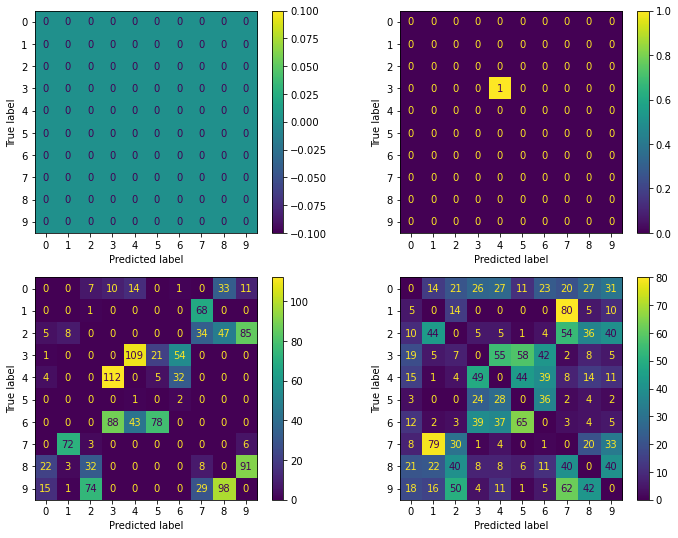

In [8]:
oof_preds = score_model(
    ExtraTreesClassifier(**PARAMS)
)

plot_confusion_matrix(train['target'],oof_preds, train_gcds)

# Custom Estimator


Fold 0: 0.97684 accuracy in 13.79s.
Fold 1: 0.9758 accuracy in 13.9s.
Fold 2: 0.97684 accuracy in 13.96s.
Fold 3: 0.97697 accuracy in 14.05s.
Fold 4: 0.97619 accuracy in 13.94s.
Fold 5: 0.97645 accuracy in 13.95s.
Fold 6: 0.97645 accuracy in 13.89s.
Fold 7: 0.976 accuracy in 13.99s.

Accuracy (1M Reads): 1.0
Accuracy (100k Reads): 1.0
Accuracy (1k Reads): 0.91661
Accuracy (100 Reads): 0.89018
Average Accuracy: 0.97644
Training Time: 111.47s


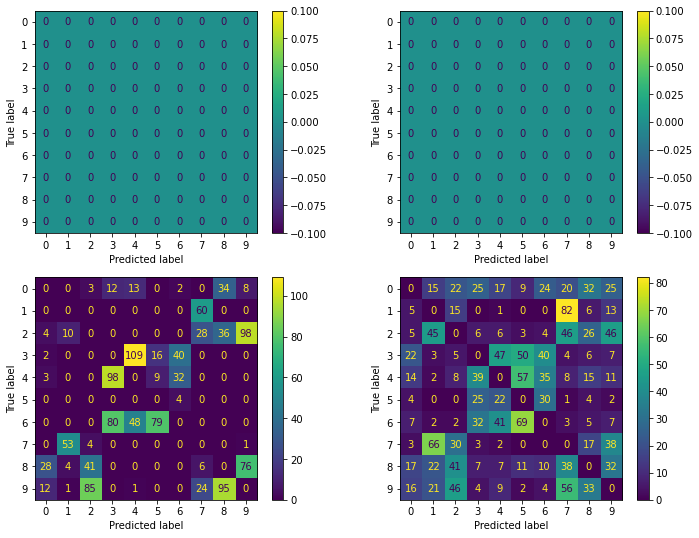

In [9]:
oof_preds = score_model(GCDEstimator())

plot_confusion_matrix(train['target'],oof_preds, train_gcds)